# RL and Advanced DL: Домашнее задание 1

_Студент MADE ML-32 Кругликов Александр_

### Часть I, с блекджеком и стратегиями

###  Задание 1.	
_Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии._

In [34]:
from collections import defaultdict

import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
env = gym.make('Blackjack-v0', natural=True)

In [8]:
def simple_policy(val):
    return 0 if val >= 19 else 1


def run_simple_policy(env, n_steps):
    """
    Params
    ------
    env:
        Среда
    n_steps:
        Количество экспериментов
    """
    rewards = []
    for i in tqdm(range(n_steps)):
        observation = env.reset()
        while True:
            action = simple_policy(observation[0])
            observation, reward, done, info = env.step(action)
            if done:
                rewards.append(reward)
                break
                
    return np.asarray(rewards)


def mean_sum(array, n):
    return np.cumsum(array) / np.arange(1, n + 1)


def plot_rewards(rewards, n_steps):
    plt.figure(figsize=(15, 6))
    plt.plot(mean_sum(rewards, n_steps))
    plt.xlabel("$N$")
    plt.ylabel("Mean Reward")
    plt.grid()
    plt.show()
    
    
def print_result(rewards, n_steps):
    print(f"\nСредний ожидаемый выигрыш после {n_steps} игр: {np.mean(rewards)}")

In [85]:
n_steps = 100000
rewards = run_simple_policy(env=env, n_steps=n_steps)

  0%|          | 0/100000 [00:00<?, ?it/s]

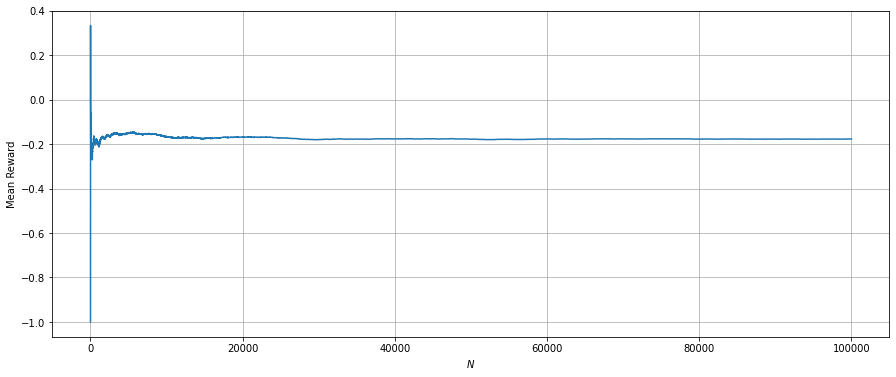


Средний ожидаемый выигрыш после 100000 игр: -0.17717


In [86]:
plot_rewards(rewards, n_steps)
print_result(rewards, n_steps)

###  Задание 2, 3
_Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym._


_Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры._

In [31]:
def run_policy(env, policy, n_steps):
    """
    Params
    ------
    env:
        Среда
    policy:
        Стратегия
    n_steps:
        Количество экспериментов
    """
    rewards = []
    for i in range(n_steps):
        env.reset()
        while True:
            action = np.argmax(policy(env._get_obs()))
            observation, reward, done, info = env.step(action)
            if done:
                rewards.append(reward)
                break
                
    return np.asarray(rewards)

In [10]:
def epsilon_greedy(env, Q, epsilon):
    def policy(obs):
        num_actions = env.action_space.n
        probs = np.ones(num_actions) * epsilon / num_actions
        best_action = np.argmax(Q[obs])
        probs[best_action] = 1.0 - epsilon + (epsilon / num_actions)
        return probs
    return policy

In [11]:
def get_policy_by_mc_control(env, n_steps, gamma, epsilon):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = epsilon_greedy(env, Q, epsilon)
    for i in range(1, n_steps + 1):
        episode = []
        state = env.reset()
        is_done = False
        while not is_done:
            probs = pol(state) 
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_state, reward, is_done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (gamma ** i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    return pol

In [12]:
def get_policy_by_q_learning(env, n_steps, gamma, epsilon, alpha):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(1, n_steps + 1):
        eps = max(1.0 / i, epsilon)
        curr_state = env.reset()
        while True:
            probs = epsilon_greedy(env, Q, eps)(curr_state)
            curr_act = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(curr_act)
            if not done: 
                next_act = np.argmax(Q[next_state]) 
                td_target = reward + gamma * Q[next_state][next_act]
                td_error = td_target - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                curr_state = next_state
            if done: 
                td_error = reward - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                break
    pol = epsilon_greedy(env, Q, eps)
    return pol

### On-policy Monte Carlo control

  0%|          | 0/100000 [00:00<?, ?it/s]

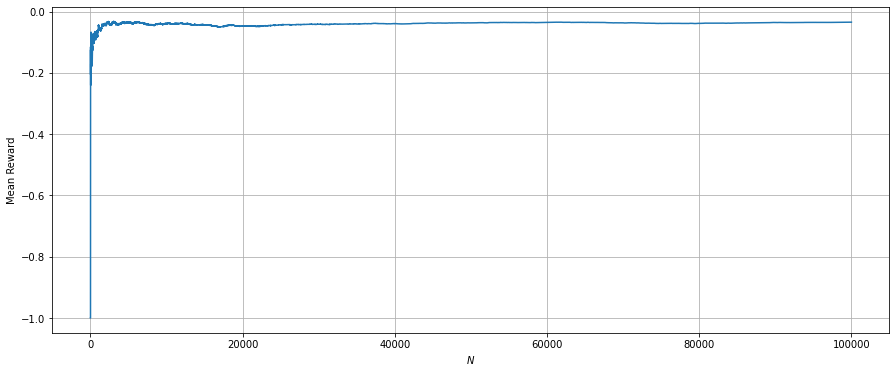


Средний ожидаемый выигрыш после 100000 игр: -0.03471


In [110]:
n_steps = 100000
gamma = 0.9
epsilon = 0.1
mc_policy = get_policy_by_mc_control(env, n_steps, gamma, epsilon)

mc_policy_reward = run_policy(env, mc_policy, n_steps)

plot_rewards(mc_policy_reward, n_steps)
print_result(mc_policy_reward, n_steps)

### Q-learning

  0%|          | 0/100000 [00:00<?, ?it/s]

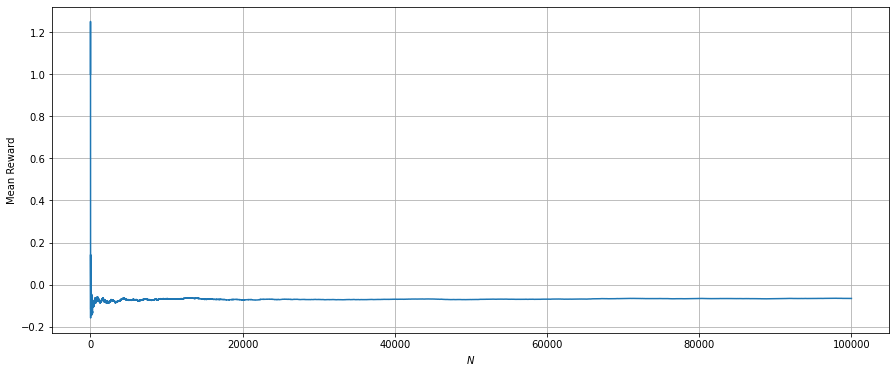


Средний ожидаемый выигрыш после 100000 игр: -0.065105


In [111]:
n_steps = 100000
gamma = 0.95
epsilon = 0.1
alpha = 0.001
q_policy  = get_policy_by_q_learning(env, n_steps, gamma, epsilon, alpha)

q_policy_reward = run_policy(env, q_policy, n_steps)

plot_rewards(q_policy_reward, n_steps)
print_result(q_policy_reward, n_steps)

- В результате подбора гиперпараметров Монте-Карло показал лучший результат: -0.03471
- Результат Q-learning: -0.065105
- Казино обыграть не удается

### Часть II, удвоенная

###  Задание 4.	
_Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки._

In [5]:
def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21

def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)

def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

class CustomBlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # add third action
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:  # double action
            self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            reward *= 2 # double reward
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()
    
    def show_cards(self):
        return self.player

###  Задание 5.	
_Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2._

In [6]:
env = CustomBlackjackEnv(natural=True)

### On-policy Monte Carlo control

  0%|          | 0/100000 [00:00<?, ?it/s]

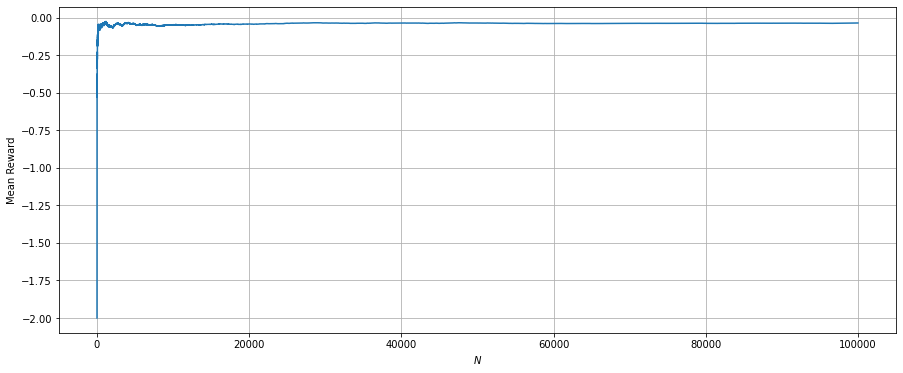


Средний ожидаемый выигрыш после 100000 игр: -0.034595


In [19]:
n_steps = 100000
gamma = 0.9
epsilon = 0.1
mc_policy = get_policy_by_mc_control(env, n_steps, gamma, epsilon)

mc_policy_reward = run_policy(env, mc_policy, n_steps)

plot_rewards(mc_policy_reward, n_steps)
print_result(mc_policy_reward, n_steps)

### Q-learning

  0%|          | 0/100000 [00:00<?, ?it/s]

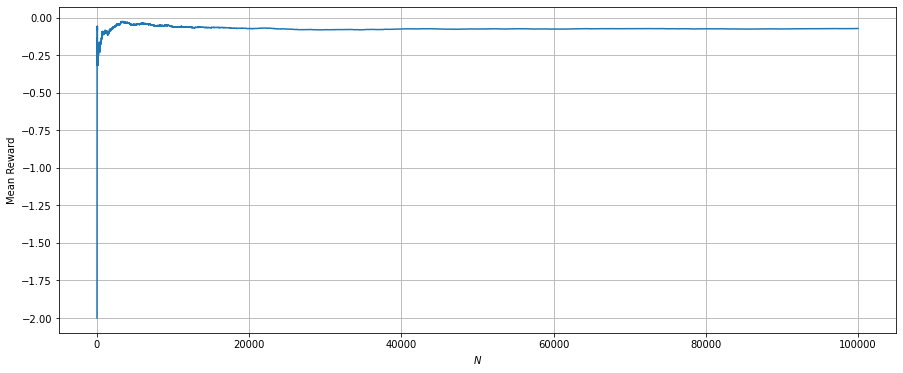


Средний ожидаемый выигрыш после 100000 игр: -0.07181


In [14]:
n_steps = 100000
gamma = 0.95
epsilon = 0.1
alpha = 0.001
q_policy  = get_policy_by_q_learning(env, n_steps, gamma, epsilon, alpha)

q_policy_reward = run_policy(env, q_policy, n_steps)

plot_rewards(q_policy_reward, n_steps)
print_result(q_policy_reward, n_steps)

Подберем параметры для Монте-Карло

In [32]:
def grid_search(env, n_steps):
    result = np.zeros(shape=(5, 5))
    gamma = [0.8, 0.85, 0.9, 0.95, 1]
    epsilon = [0.05, 0.1, 0.15, 0.2, 0.25]
    
    for i in tqdm(range(len(gamma))):
        for j in range(len(epsilon)):
            mc_policy = get_policy_by_mc_control(env, n_steps, gamma=gamma[i], epsilon=epsilon[j])
            mc_policy_reward = run_policy(env, mc_policy, n_steps)
            result[i, j] = np.mean(mc_policy_reward)
            
    best_gamma_idx, best_epsilon_idx = np.unravel_index(np.argmax(result), result.shape)
    best_gamma = gamma[best_gamma_idx]
    best_epsilon = epsilon[best_epsilon_idx]
    best_reward = result[best_gamma_idx, best_epsilon_idx]
    return result, best_reward, best_gamma, best_epsilon

In [33]:
n_steps = 100000
result, best_reward, best_gamma, best_epsilon = grid_search(env, n_steps)

  0%|          | 0/5 [00:00<?, ?it/s]

In [36]:
print(f"best_gamma: {best_gamma}, best_epsilon: {best_epsilon}")

best_gamma: 0.95, best_epsilon: 0.15


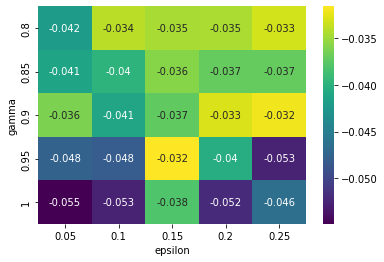

In [38]:
ax = sns.heatmap(result, annot=True, cmap="viridis")
ax.set(xlabel="epsilon", ylabel="gamma")
ax.set_xticklabels([0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_yticklabels([0.8, 0.85, 0.9, 0.95, 1])
plt.show()

Запустим на лучших параметрах

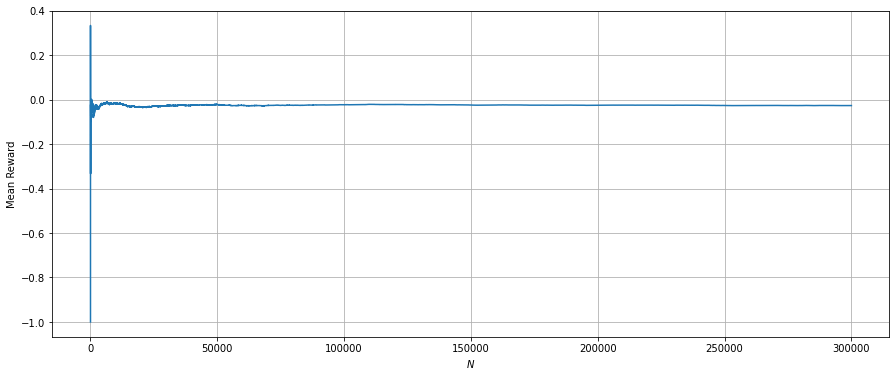


Средний ожидаемый выигрыш после 300000 игр: -0.026828333333333333


In [39]:
n_steps = 300000
gamma = 0.95
epsilon = 0.15
mc_policy = get_policy_by_mc_control(env, n_steps, gamma, epsilon)

mc_policy_reward = run_policy(env, mc_policy, n_steps)

plot_rewards(mc_policy_reward, n_steps)
print_result(mc_policy_reward, n_steps)

- В бекджеке с удвоением Монте-Карло по прежнему показывает себя лучше с результатом на 100к итераций: -0.034595, против Q-learning: -0.07181
- В результате подбора гиперпараметров и запуске 300к итераций, Монте-Карло показал: -0.026828
- Мы все еще проигрываем казино

### Часть III, в главной роли — Дастин Хоффман

###  Задание 6.	
_Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет)._

In [54]:
class HoffmanBlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()
        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        self.const_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.deck = self.const_deck * 4
        self.plus_minus = {2: 1,
                           3: 1,
                           4: 1,
                           5: 1,
                           6: 1,
                           7: 0,
                           8: 0,
                           9: 0,
                           10: -1,
                           1: -1}
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def cards_count(self, deck):
        return len(deck)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:  # double action
            self.player.append(self.draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), 
                np.sum([self.plus_minus[card] for card in self.deck])) 

    def reset(self):
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        
        if self.cards_count(self.deck) <= 15:
            self.deck = self.const_deck * 4
        return self._get_obs()
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        return card
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def show_cards(self):
        return self.player

###  Задание 7.	
_Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2._

In [55]:
env = HoffmanBlackjackEnv(natural=True)

### On-policy Monte Carlo control

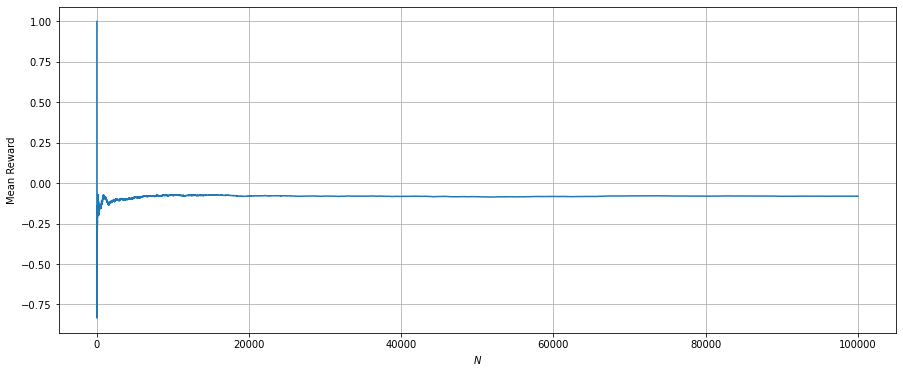


Средний ожидаемый выигрыш после 100000 игр: -0.0802


In [43]:
n_steps = 100000
gamma = 0.9
epsilon = 0.1
mc_policy = get_policy_by_mc_control(env, n_steps, gamma, epsilon)

mc_policy_reward = run_policy(env, mc_policy, n_steps)

plot_rewards(mc_policy_reward, n_steps)
print_result(mc_policy_reward, n_steps)

### Q-learning

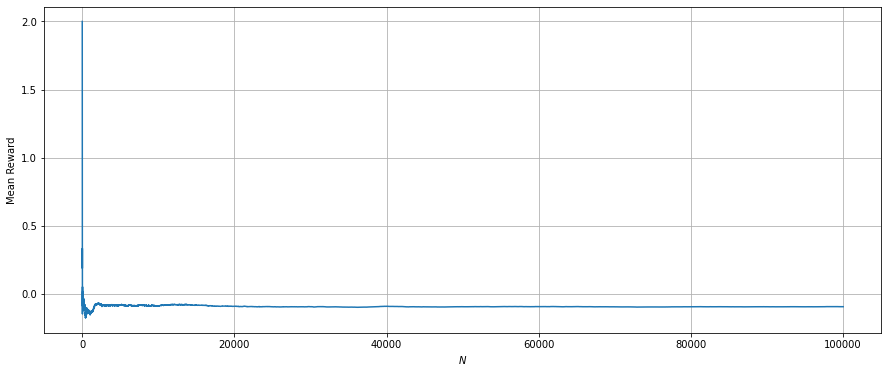


Средний ожидаемый выигрыш после 100000 игр: -0.094555


In [44]:
n_steps = 100000
gamma = 0.95
epsilon = 0.1
alpha = 0.001
q_policy  = get_policy_by_q_learning(env, n_steps, gamma, epsilon, alpha)

q_policy_reward = run_policy(env, q_policy, n_steps)

plot_rewards(q_policy_reward, n_steps)
print_result(q_policy_reward, n_steps)

Подберем параметры для Монте-Карло

In [45]:
n_steps = 100000
result, best_reward, best_gamma, best_epsilon = grid_search(env, n_steps)

  0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
print(f"best_gamma: {best_gamma}, best_epsilon: {best_epsilon}")

best_gamma: 0.8, best_epsilon: 0.2


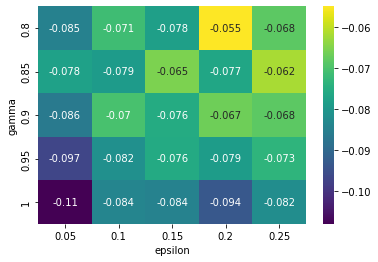

In [47]:
ax = sns.heatmap(result, annot=True, cmap="viridis")
ax.set(xlabel="epsilon", ylabel="gamma")
ax.set_xticklabels([0.05, 0.1, 0.15, 0.2, 0.25])
ax.set_yticklabels([0.8, 0.85, 0.9, 0.95, 1])
plt.show()

Запустим на лучших параметрах

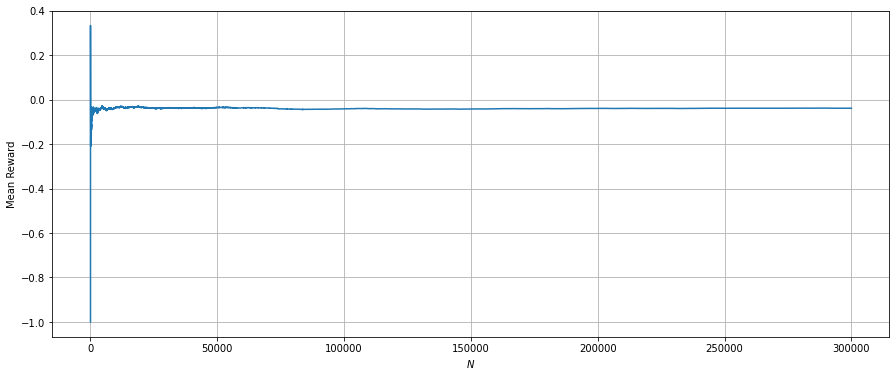


Средний ожидаемый выигрыш после 300000 игр: -0.03885333333333333


In [58]:
n_steps = 300000
gamma = 0.8
epsilon = 0.2
mc_policy = get_policy_by_mc_control(env, n_steps, gamma, epsilon)

mc_policy_reward = run_policy(env, mc_policy, n_steps)

plot_rewards(mc_policy_reward, n_steps)
print_result(mc_policy_reward, n_steps)

- Подсчет карт не позволил улучшить результат при сравнении с игрой с удвоением, результат составил на 300к итерациях: -0.034595, против -0.038853
- Лучший результат Монте-Карло на 300к итераций: -0.026828

- Не везет в картах, повезет в любви